# Assignment 2 - Stitching

_Tiffany Wang - 260684152_ 

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from PIL import Image

#### 1. Compute SIFT keypoints and corresponding descriptors for images 1Hill and 2Hill.


In [2]:
hill1 = Image.open('./stitching_images/1Hill.JPG')
hill2 = Image.open('./stitching_images/2Hill.JPG')
hill3 = Image.open('./stitching_images/3Hill.JPG')

hill1 = np.array(hill1)
hill2 = np.array(hill2)
hill3 = np.array(hill3)

h1, w1, _ = hill1.shape
h2, w2, _ = hill2.shape
h3, w3, _ = hill3.shape

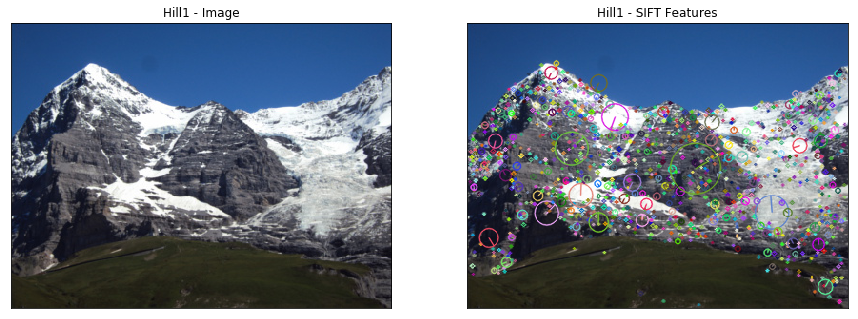

descriptors size: (1254, 128)


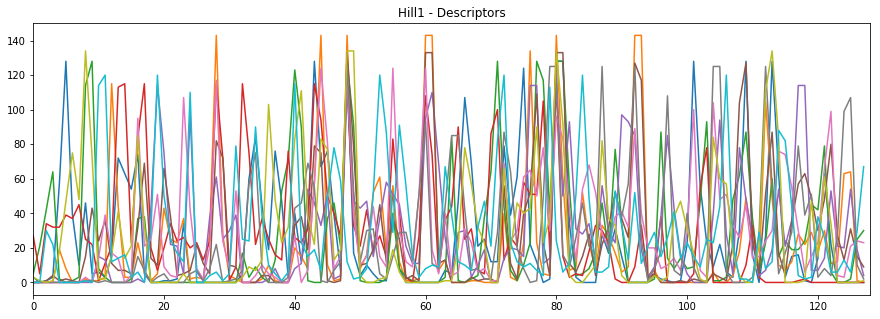

In [3]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 1Hill #
###############################################################

# copy of image 
hill1 = np.array(hill1)
hill1_c = hill1.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp1, des1 = sift.detectAndCompute(hill1, None)

# draw the keypoints
cv2.drawKeypoints(hill1, kp1, hill1_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill1)
plt.title("Hill1 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill1_c)
plt.title("Hill1 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()

# num of SIFT descriptors
print('descriptors size: '+ str(des1.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill1 - Descriptors')
for i in range(num):
    plt.plot(des1[i])
    plt.xlim([0,128]) 
plt.show()

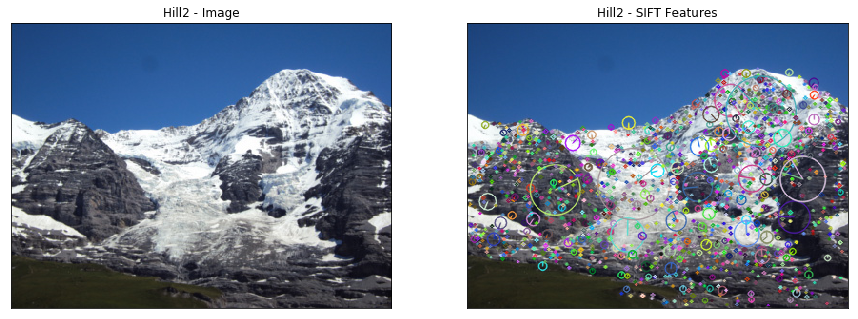

descriptors size: (1472, 128)


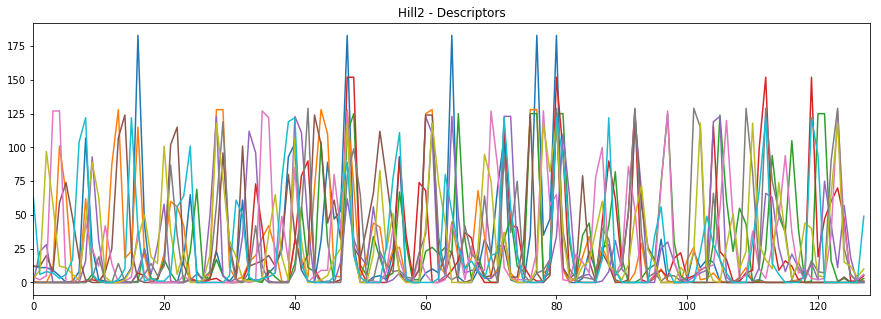

In [4]:
###############################################################
# Find SIFT keypoints and corresponding descriptors for 2Hill #
###############################################################

# copy of image 
hill2 = np.array(hill2)
hill2_c = hill2.copy()

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
kp2, des2 = sift.detectAndCompute(hill2, None)

# draw the keypoints
cv2.drawKeypoints(hill2, kp2, hill2_c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# display
plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(hill2)
plt.title("Hill2 - Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(hill2_c)
plt.title("Hill2 - SIFT Features"), plt.xticks([]), plt.yticks([])
plt.show()


# num of SIFT descriptors
print('descriptors size: '+ str(des2.shape))

# plot a couple of 1x128 SIFT descriptors
num = 10
plt.figure(figsize=(15, 5))
plt.title('Hill2 - Descriptors')
for i in range(num):
    plt.plot(des2[i])
    plt.xlim([0,128]) 
plt.show()

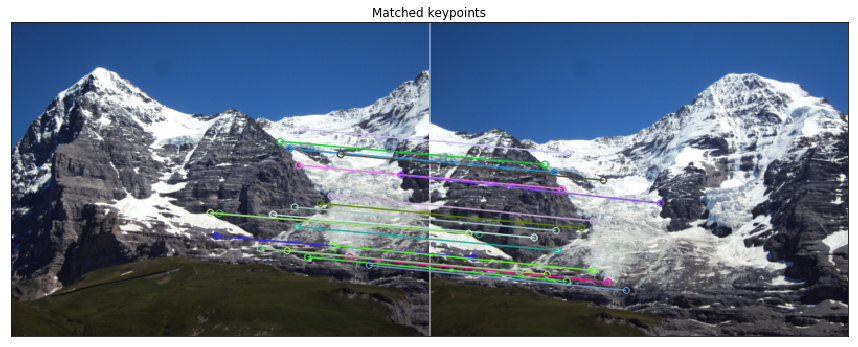

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
nb = 20
match_res = cv2.drawMatches(hill1,kp1, hill2, kp2, matches[:nb], hill1, flags=2)

plt.figure(figsize=(15,15))
plt.imshow(match_res)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

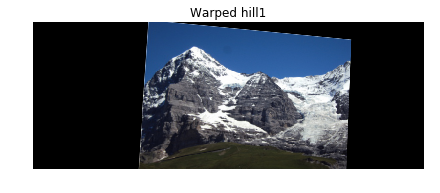

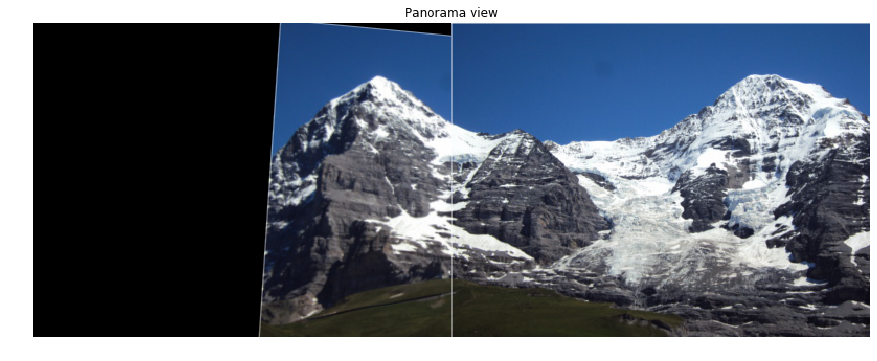

In [6]:
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
# GoodMatches = GoodMatches[:-1]
pts_r = np.float32([kp2[i].pt for (i, __) in GoodMatches])
pts_l = np.float32([kp1[i].pt for (__, i) in GoodMatches])

# We shift all the points in the right image over as they are on smaller canvas
for i in range(len(pts_r)):
    pts_r[i][0] += hill2.shape[1]

M, _ = cv2.findHomography(pts_l, pts_r, cv2.RANSAC, 5)

# Use homography
warped = cv2.warpPerspective(hill1, M, (w1 + w2, h2))

plt.figure(figsize=(7,7))
plt.imshow(warped)
plt.title("Warped hill1"), plt.axis('off')
plt.show()

glued = warped.copy()
glued[:, w2:,:] = hill2
plt.figure(figsize=(15,15))
plt.imshow(glued)
plt.title("Panorama view"), plt.axis('off')
plt.show()

In [57]:
A = warped[:, :w1]
B = hill2
# B = np.zeros((h2, w2 * 2, 3))
# B[:, w2:] = hill2

depth = 6

# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv2.pyrDown(G)
    gpA.append(G)

# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv2.pyrDown(G)
    gpB.append(G)

# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv2.pyrUp(gpA[i], dstsize=(gpA[i-1].shape[1], gpA[i-1].shape[0]))
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)

# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv2.pyrUp(gpB[i], dstsize=(gpB[i-1].shape[1], gpB[i-1].shape[0]))
    L = cv2.subtract(gpB[i-1],GE)
    lpB.append(L)

# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la, lb))
    LS.append(ls)

# now reconstruct
ls_ = LS[0]
for i in range(1,6):
    ls_ = cv2.pyrUp(ls_, dstsize=(LS[i].shape[0], LS[i].shape[1]))
    ls_ = cv2.add(ls_, LS[i])

# display results
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(ls_.astype(np.uint8))
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])
plt.show()

SyntaxError: invalid syntax (<ipython-input-57-950ebd13a895>, line 32)